In [1]:
from prototype04_cbcsnrs import CBCSNRsBase, compute_bilby_snr
import numpy as np
import pylab as plt
import bilby
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from pycbc.detector import Detector
from datetime import datetime

# modified Findchirp method, or Half Scaling method. 
* SNR : $$ \rho= \left( \frac{1 Mpc}{D_{eff}} \right)\mathcal{A}_{1Mpc} \sqrt{ 4\int_0^\infty \frac{f^{-7/3}}{S_n(f)}df } $$

* Half scaled SNR : $$ \rho_{1/2} = \left( \frac{D_{eff}}{1 Mpc} \right)\mathcal{A}_{1Mpc}^{-1} \times \rho $$
                    $$ \rho_{1/2} = \sqrt{ 4\int_0^\infty \frac{f^{-7/3}}{S_n(f)}df } $$
                    
* It shouldn't depend on the GW parameters
* It depends on the noise curve of the detector : $S_n(f)$

# taking care of units
* $\mathcal{M}$ : chirp mass in $M_{\odot}$, $\mathcal{D}$: luminosity distance in Mpc. 
* $F_+,F_{\times}$: Antenna pattern, $\iota$: inclination angle
$$\mathcal{A}_{1Mpc}=\left(\frac{5}{24\pi}\right)^{1/2}\left(\frac{GM_{\odot}/c^2}{1Mpc}\right)\left(\frac{\pi GM_{\odot}}{c^3}\right)^{-1/6}\left(\frac{\mathcal{M}}{M_{\odot}}\right)^{5/6} $$
$$ \mathcal{D}_{eff} = \mathcal{D}\left[ F_+^2\left(\frac{1+cos^2\iota}{2}\right)^2 + F_{\times}^2 cos^2\iota \right]^{-1/2} $$ 

* Half scaled SNR : 
$$ \rho_{1/2} = \left( \frac{D_{eff}}{1 Mpc} \right) \mathcal{M}^{-5/6} \times \rho $$
$$ \rho_{1/2} = \left(\frac{5}{24\pi}\right)^{1/2}\left(\frac{GM_{\odot}/c^2}{1Mpc}\right)\left(\frac{\pi GM_{\odot}}{c^3}\right)^{-1/6}\left(\frac{1}{M_{\odot}}\right)^{5/6} \sqrt{ 4\int_0^\infty \frac{f^{-7/3}}{S_n(f)}df } $$

* Putting a upper integration limit at $f_{ISCO}$ lower limit to a chosen $f_{min}$
$$ f_{ISCO} = \frac{f c^3}{ G M_{tot}\pi 6^{3/2} } $$
$$ \rho_{1/2} = \left(\frac{5}{24\pi}\right)^{1/2}\left(\frac{GM_{\odot}/c^2}{1Mpc}\right)\left(\frac{\pi GM_{\odot}}{c^3}\right)^{-1/6}\left(\frac{1}{M_{\odot}}\right)^{5/6} \sqrt{ 4\int_{f_{min}}^{f_{ISCO}} \frac{f^{-7/3}}{S_n(f)}df } $$

# Bilby's SNR

In [260]:
# Hemanta's code
# for an array of each parameter
# only for freqency domain waveform
# 3 detector case
# zero spin
# let geocent time be fixed (according to a selected observing run)
def compute_bilby_snr_(mass_1, mass_2, luminosity_distance=100., theta_jn=0., \
                      psi=0., phase=0., geocent_time=1246527224.169434, ra=0., dec=0., duration=16.0, sampling_frequency=4096, \
                      waveform_arguments=  dict(waveform_approximant = "TaylorF2", reference_frequency = 20., \
                                                minimum_frequency = 20) ):
    nn = len(mass_1) 
    mass_1_, mass_2_, luminosity_distance_, \
    theta_jn_, psi_, phase_, ra_, dec_ = np.array([mass_1]).reshape(-1), np.array([mass_2]).reshape(-1), \
                                        np.array([luminosity_distance]).reshape(-1)*np.ones(nn), np.array([theta_jn]).reshape(-1)*np.ones(nn), \
                                        np.array([psi]).reshape(-1)*np.ones(nn), np.array([phase]).reshape(-1)*np.ones(nn), \
                                        np.array([ra]).reshape(-1)*np.ones(nn), np.array([dec]).reshape(-1)*np.ones(nn)
    
    bilby.core.utils.logger.disabled = True
    np.random.seed(88170235)
    nsamples = np.size(mass_1_)
    
    # initialize interferometer object
    # it is ideal to initialized it outside the for loop
    waveform_generator = bilby.gw.WaveformGenerator(
            duration=duration,
            sampling_frequency=sampling_frequency,
            frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
            parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
            waveform_arguments=waveform_arguments,)
    
    ifos_ = bilby.gw.detector.InterferometerList(["L1", "H1", "V1"])
    ifos_.set_strain_data_from_power_spectral_densities(
        sampling_frequency=sampling_frequency,
        duration=duration,
        start_time=geocent_time - 16,
    )
    
    opt_snr0 = []
    opt_snr1 = []
    opt_snr2 = []
    # f_max=4096/2  
    for i in range(nsamples):
        ifos = ifos_
        injection_parameters = dict(mass_1=mass_1_[i],mass_2=mass_2_[i],a_1=0.,a_2=0.,tilt_1=0.,tilt_2=0.,phi_12=0.,\
                                    phi_jl=0.,luminosity_distance=luminosity_distance_[i],theta_jn=theta_jn_[i],psi=psi_[i], \
                                    phase=phase_[i],geocent_time=geocent_time,ra=ra_[i],dec=dec_[i])
        ifos.inject_signal(
            waveform_generator=waveform_generator, parameters=injection_parameters, raise_error=False
        );
        
        opt_snr0.append(ifos[0].meta_data['optimal_SNR'])
        opt_snr1.append(ifos[1].meta_data['optimal_SNR'])
        opt_snr2.append(ifos[2].meta_data['optimal_SNR'])
        
    opt_snr0,opt_snr1,opt_snr2 = np.array(opt_snr0),np.array(opt_snr1),np.array(opt_snr2)
    opt_snr_net = np.sqrt(opt_snr0**2 + opt_snr1**2 + opt_snr2**2)

    return(np.array([opt_snr0, opt_snr1, opt_snr2, opt_snr_net]))

# Simple Quintet

In [295]:
# for delta_f =1/duration, duration = 16s  
# O3 sensitivity 
# f_min =20Hz
# duration=16.0, sampling_frequency=4096,
# waveform_arguments=  dict(waveform_approximant = "TaylorF2", reference_frequency = 20., minimum_frequency = 20),
class quintet():
    def __init__(self, mass_1, mass_2, a_1=0., a_2=0., tilt_1=0., tilt_2=0., phi_12=0., phi_jl=0., luminosity_distance=100., \
                 theta_jn=0., psi=0., phase=0., geocent_time=1246527224.169434, ra=0., dec=0., \
                 list_of_detectors=['L1', 'H1', 'V1'], sensitivity='O3' ):
        self.mass_1 = mass_1
        self.mass_2 = mass_2
        self.mtot = mass_1+mass_2
        self.chirp_mass = ( (mass_1*mass_2)**(3/5) )/( (mass_1+mass_2)**(1/5) )
        self.a_1 = a_1
        self.a_2 = a_2
        self.tilt_1 = tilt_1
        self.tilt_2 = tilt_2
        self.phi_12 = phi_12
        self.phi_jl = phi_jl
        self.luminosity_distance = luminosity_distance
        self.theta_jn = theta_jn
        self.psi = psi
        self.phase = phase
        self.geocent_time = geocent_time
        self.ra = ra
        self.dec = dec
        #self.duration = duration
        #self.sampling_frequency = sampling_frequency
        #self.waveform_arguments = waveform_arguments
        self.list_of_detectors = list_of_detectors
        self.snr_half_scaled = {'O1':[2908.4084575985235, 2908.386230780323, 2214.834585538133],\
                                'O2':[2908.5463969577872, 2908.433950278486, 2214.7834499126084],\
                                'O3':[2908.267215514583, 2908.0445632898386, 2214.6907196464626]}
        self.sensitivity = sensitivity
        
    def snr(self):
        Mc = self.chirp_mass
        mtot = self.mtot
        iota = self.theta_jn
        Dl = self.luminosity_distance
        psi = self.psi
        ra = self.ra
        dec = self.dec
        geocent_time = self.geocent_time
        
        # O1 snr_HalfScaled = [2908.2661468129972, 2908.0417461038714, 2214.693865936319] for L1,H1,V1 respectively from numerical fitting
        A1 = Mc**(5./6.)
        ci_2 = np.cos(iota)**2
        ci_param = ((1+np.cos(iota)**2)/2)**2
        detectors = self.list_of_detectors
        snr_half_scaled = self.snr_half_scaled[self.sensitivity]
        det_ = {'L1':0,'H1':1,'V1':2}
        
        snr_arr = []
        net_snr = 0.
        for det in detectors:
            Fp, Fc = Detector(det).antenna_pattern(ra, dec, psi, geocent_time)
            Deff1 = Dl/np.sqrt( Fp**2*ci_param + Fc**2*ci_2 )
            snr_ = (A1/Deff1)*snr_half_scaled[det_[det]]
            snr_arr.append( snr_ )
            net_snr += snr_**2

        net_snr = np.sqrt(net_snr)

        return( snr_arr, net_snr)
    

In [296]:
quintet(np.array([10,20]),np.array([10,20])).snr()

([array([142.62859778, 254.13526986]),
  array([ 90.71080947, 161.62828775]),
  array([42.81312849, 76.28432258])],
 array([174.36837967, 310.68913187]))

In [299]:
quintet(np.array([10,20]),np.array([10,20])).snr()[1]

array([174.36837967, 310.68913187])

In [297]:
compute_bilby_snr_(np.array([10,20]),np.array([10,20]))

array([[142.62859778, 254.13526986],
       [ 90.71080947, 161.62828775],
       [ 42.81312849,  76.28432258],
       [174.36837967, 310.68913187]])

In [300]:
compute_bilby_snr_(np.array([10,20]),np.array([10,20]))[3]

array([174.36837967, 310.68913187])

In [301]:
# gerneral case, random parameters
# chirp mass can go upto only 95 if f_min=20.
nsamples = 50
chirp_mass = np.linspace(10,95,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase, geocent_time = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(12933,1529132, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [302]:
quint_=quintet(mass_1=mass_1, mass_2=mass_2, a_1=0., a_2=0., tilt_1=0., tilt_2=0., phi_12=0., phi_jl=0., luminosity_distance=luminosity_distance, \
                 theta_jn=theta_jn, psi=psi, phase=phase, geocent_time=1246527224.169434, ra=ra, dec=ra, \
                 list_of_detectors=['L1', 'H1', 'V1'], sensitivity='O3' )

In [303]:
mine_ = quint_.snr()

In [304]:
bilby_ = compute_bilby_snr_(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, theta_jn=theta_jn, \
                            psi=psi, phase=phase, ra=ra, dec=dec)

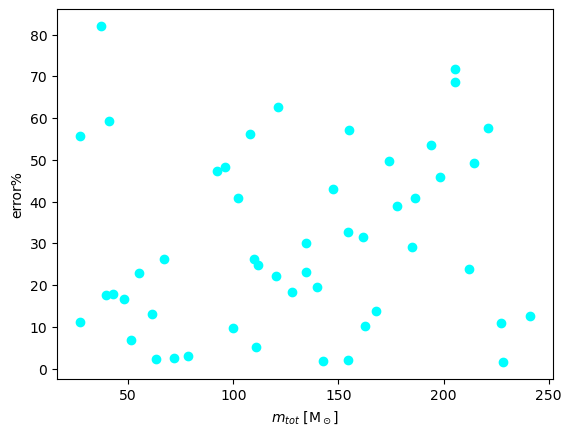

In [305]:
plt.plot(total_mass, np.abs(bilby_[3]-mine_[1])/bilby_[3]*100, 'o', color='cyan')
plt.xlabel(r"$m_{tot}$ [$\rm M_\odot$]")
plt.ylabel(r"error%")
plt.show()

# Complicated quintet O3

In [59]:
# for delta_f =1/duration, duration = 16s  
# f_min =20Hz
# duration=16.0, sampling_frequency=4096,
# note: setting mtot_min and mtot_max is important.
# mtot_min=219. is accordance to minimum_frequency = 20
# __init__ paramters are important don't to change for a particular analysis
# they are detector and waveform dependent parameters
# at f_min==10Hz: mtot_max=439.6 
C = 299792458.
G = 6.67408*1e-11
Mo = 1.989*1e30

class quintet():
    def __init__(self, mtot_min=2., mtot_max=439.6, nsamples=20, list_of_detectors=['L1', 'H1', 'V1'], sensitivity='O3', \
                duration=16., sampling_frequency=4096.,\
                waveform_arguments= dict(waveform_approximant = "TaylorF2", \
                                               reference_frequency = 20., minimum_frequency = 20)):
        
        '''
        Initialized parameters and functions
        snr_half_scaled() : function for finding (f/PSD) integration in the limit [f_min,f_max]
        list_of_detectors :  list of detector initials, e.g. L1 for Livingston
        sensitivity : detectors sensitivity at various runs
        f_min : 
        '''
        self.mtot_min = mtot_min
        self.mtot_max = mtot_max
        self.nsamples = nsamples
        self.list_of_detectors = list_of_detectors
        
        self.duration = duration
        self.sampling_frequency = sampling_frequency
        self.waveform_arguments = waveform_arguments
        self.list_of_detectors = list_of_detectors
        self.sensitivity = sensitivity
        self.f_min = waveform_arguments['minimum_frequency']
        
        # pre-initialized half scaled snr with search sort
        # self.halfSNR values are initialized
        self.__init_halfScaled() # you can also reinitialized this
    
    def snr(self, mass_1, mass_2, luminosity_distance=100., iota=0., \
            psi=0., phase=0., geocent_time=1246527224.169434, ra=0., dec=0.):
        
        mass_1, mass_2 = np.array([mass_1]).reshape(-1), np.array([mass_2]).reshape(-1)
        num = len(mass_1)
        luminosity_distance, theta_jn, psi, phase, ra, dec = np.array([luminosity_distance]).reshape(-1)*np.ones(num), \
                                        np.array([iota]).reshape(-1)*np.ones(num), \
                                        np.array([psi]).reshape(-1)*np.ones(num), \
                                        np.array([phase]).reshape(-1)*np.ones(num), \
                                        np.array([ra]).reshape(-1)*np.ones(num), \
                                        np.array([dec]).reshape(-1)*np.ones(num)
        
        Mc = ( (mass_1*mass_2)**(3/5) )/( (mass_1+mass_2)**(1/5) )
        mtot = mass_1+mass_2
        Dl = luminosity_distance
        
        # geocnet should be in one of the observing run
        # make the geocent time variable
        sesitivity_ = {'O1':1126259462.4, 'O2':1187008672.43, 'O3':1246527224.169434 }
        geocent_time_ = sesitivity_[self.sensitivity]
        
        # dealing with mtot array
        # mtot > mtot_max will be have snr = 0.
        snr_half_scaled = np.zeros(num) # for mtot > mtot_max, set zero value will not change later
        idx2 = np.array(np.where(self.mtot_max>mtot)).reshape(-1).tolist() # record index with mtot values less than mtot_max
        # getting simple snr_half_scaled values for interpolation
        halfSNR_ = self.halfSNR
        idx = np.searchsorted(halfSNR_['mtot'], mtot[idx2])
        #print(idx, ',', idx2,',',self.mtot_max)
        
        A1 = Mc**(5./6.)
        ci_2 = np.cos(iota)**2
        ci_param = ((1+np.cos(iota)**2)/2)**2
        detectors = self.list_of_detectors
        
        opt_snr = {'opt_snr_net': 0}
        
        for det in detectors:
            # calculation of snr_half_scaled for particular detector at the required mtot
            y2 = halfSNR_[det][idx]
            x2 = halfSNR_['mtot'][idx]
            y1 = halfSNR_[det][idx-1]
            x1 = halfSNR_['mtot'][idx-1]
            #print(type(y1),'\n',type(x1),'\n',type(mtot[idx2]),'\n',type(snr_half_scaled))
            snr_half_scaled[idx2] = ((y2-y1)/(x2-x1))*(mtot[idx2]-x1) + y1
            
            Fp, Fc = Detector(det).antenna_pattern(ra, dec, psi, geocent_time)
            Deff1 = Dl/np.sqrt( Fp**2*ci_param + Fc**2*ci_2 )
            
            opt_snr[det] = (A1/Deff1)*snr_half_scaled
            opt_snr['opt_snr_net'] += opt_snr[det]**2

        opt_snr['opt_snr_net'] = np.sqrt(opt_snr['opt_snr_net'])

        return( opt_snr )
        

    '''
    Function for finding (f/PSD) integration in the limit [f_min,f_max]
    f_min is already initialized
    f_max is taken as 'last stable orbit frequency' is a function of mtot
    __init_halfScaled(self) returns a small array which will be used for interpolation inside the object snr(self)
    '''
    #################################################################################
    ##################### half_snr vs mtot table for interpolation ##################
    #################################################################################
    def __init_halfScaled(self):
        '''
        Returns values:
        snr_half_scaled values at various mtot points between mtot=1Mo and mtot_max(intialized). 
        mtot_max is a function of f_min 
        for mtot>mtot_max, snr_half_scaled values=0.
        '''
        mtot_min = self.mtot_min
        mtot_max = self.mtot_max
        nsamples = self.nsamples
        detectors = self.list_of_detectors
        
        try:
            if  mtot_min<2.:
                raise ValueError
        except ValueError:
            print('Error: mass too low')
        
        C = 299792458.
        G = 6.67408*1e-11
        Mo = 1.989*1e30
        f_min = self.f_min
        mtot_max_propose = (C**3)/( G*Mo*f_min*np.pi*6**(3/2) )
        
        if mtot_max_propose<mtot_max:
            mtot_max = mtot_max_propose
            self.mtot_max = mtot_max
        
        mtot_table = np.sort(mtot_min+mtot_max-np.geomspace(mtot_min,  mtot_max, nsamples))
        #mtot_table = np.geomspace(mtot_min,  mtot_max, nsamples)
        #mtot_table = np.linspace(mtot_min,  mtot_max, nsamples)
        
        mass_1_ = mtot_table/2
        mass_2_ = mass_1_
        mchirp = ( (mass_1_*mass_2_)**(3/5) )/( (mtot_table)**(1/5) )
        
        # observing run and chosen geocent time in that observing run
        # here i have assumed the sesitivity remains the same within each observing run
        sesitivity_ = {'O1':1126259462.4, 'O2':1187008672.43, 'O3':1246527224.169434 }

        # geocent_time cannot be array here
        geocent_time_ = sesitivity_[self.sensitivity]
    
        iota_, ra_, dec_, psi_, phase_ = 0.,0.,0.,0.,0.
        luminosity_distance_ = 100.
        ######## calling bilby_snr ########
        opt_snr_unscaled = self.compute_bilby_snr_(mass_1=mass_1_, mass_2=mass_2_, luminosity_distance=luminosity_distance_, \
                                                theta_jn=iota_, psi=psi_, ra=ra_, dec=dec_)  
        '''
        example of opt_snr_unscaled return values
        {'opt_snr_net': array([156.53268655, 243.00092419, 292.10396943]),
         'L1': array([132.08275995, 205.04492349, 246.47822334]),
         'H1': array([ 84.00372897, 130.40716432, 156.75845871])}
         '''

        A2 = mchirp**(5./6.)
        ######## filling in interpolation table for different detectors ########
        snrHalf_det = {}
        for det in detectors:
            Fp, Fc = Detector(det).antenna_pattern(ra_, dec_, psi_, geocent_time_)
            Deff2 = luminosity_distance_/np.sqrt(Fp**2*((1+np.cos(iota_)**2)/2)**2+Fc**2*np.cos(iota_)**2 )
            snrHalf_det[det]=(Deff2/A2)*opt_snr_unscaled[det]
        
        # 2D array size: n_detectors X nsamples np.concatenate((a, b), axis=0)
        snrHalf_det['mtot'] = mtot_table
        #print(snrHalf_det)
        self.halfSNR = snrHalf_det
        return(snrHalf_det)
    
    #######################################################################
    ##################### bilby snr with frequency limit ##################
    #######################################################################
    '''
    Don't need initialization to run this 
    '''
    def compute_bilby_snr_(self, mass_1, mass_2, luminosity_distance=100., theta_jn=0., \
                            psi=0., phase=0., geocent_time=1246527224.169434, ra=0., dec=0.):
        '''
        parameters:
        
        return vales
        opt_snr : dictionary of SNRs of different detectors. e.g keys: ['L1','H1','net_snr']  
        '''
        duration = self.duration
        sampling_frequency = self.sampling_frequency
        waveform_arguments = self.waveform_arguments
        detectors = self.list_of_detectors
        # reshape(-1) is so that either a float value is given or the input is an numpy array
        # np.ones is multipled to make sure everything is of same length
        mass_1, mass_2 = np.array([mass_1]).reshape(-1), np.array([mass_2]).reshape(-1)
        num = len(mass_1)
        luminosity_distance, theta_jn, psi, phase, ra, dec = np.array([luminosity_distance]).reshape(-1)*np.ones(num), \
                                        np.array([theta_jn]).reshape(-1)*np.ones(num), \
                                        np.array([psi]).reshape(-1)*np.ones(num), \
                                        np.array([phase]).reshape(-1)*np.ones(num), \
                                        np.array([ra]).reshape(-1)*np.ones(num), \
                                        np.array([dec]).reshape(-1)*np.ones(num)
        mtot = mass_1+mass_2
        bilby.core.utils.logger.disabled = True
        np.random.seed(88170235)

        # initialize interferometer object
        # it is ideal to initialized it outside the for loop
        waveform_generator = bilby.gw.WaveformGenerator(
                duration=duration,
                sampling_frequency=sampling_frequency,
                frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
                parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
                waveform_arguments=waveform_arguments,)

        det_ = {'L1':0,'H1':1,'V1':2}
        ifos = bilby.gw.detector.InterferometerList(detectors)
        ifos.set_strain_data_from_power_spectral_densities(
            sampling_frequency=sampling_frequency,
            duration=duration,
            start_time=geocent_time-duration,
        )
        
        opt_snr = {'opt_snr_net': 0}
        f_min = waveform_arguments['minimum_frequency']
        for det in detectors:
            new_keys = {det:[]}
            opt_snr.update(new_keys)
            for i in range(num):
                ifos[det_[det]].minimum_frequency = f_min
                f_max = (C**3)/( G*(mtot[i])*Mo*np.pi*6**(3/2) )
                ifos[det_[det]].maximum_frequency = f_max

                injection_parameters = dict(mass_1=mass_1[i],mass_2=mass_2[i],a_1=0.,a_2=0.,tilt_1=0.,tilt_2=0.,phi_12=0.,\
                                            phi_jl=0.,luminosity_distance=luminosity_distance[i],theta_jn=theta_jn[i],psi=psi[i], \
                                            phase=phase[i],geocent_time=geocent_time,ra=ra[i],dec=dec[i])
                ifos.inject_signal(
                    waveform_generator=waveform_generator, parameters=injection_parameters, raise_error=False
                );

                opt_snr[det].append(ifos[det_[det]].meta_data['optimal_SNR'])

            opt_snr[det] = np.array(opt_snr[det])
            opt_snr['opt_snr_net'] += opt_snr[det]**2

        opt_snr['opt_snr_net'] = np.sqrt(opt_snr['opt_snr_net'])

        return(opt_snr)

In [ ]:
Fp_,Fc_ = Detector('L1').antenna_pattern(np.array([1,2]), np.array([1,2]), np.array([1,2]), 1246527224.169434)

In [ ]:
Fp_

array([0.45077069, 0.68047649])

In [ ]:
np.array([np.array([1,2,3])]).reshape(-1)

array([1, 2, 3])

In [ ]:
np.array([1]).reshape(-1)

array([1])

In [62]:
quin_ = quintet(nsamples=100,list_of_detectors=['L1','H1','V1'])

In [57]:
quin_.compute_bilby_snr_(mass_1=np.array([10.,20.,30.]), mass_2=np.array([10.,20.,30.]))

{'opt_snr_net': array([161.52595333, 250.45588625, 300.28557409,   0.        ]),
 'L1': array([132.08275995, 205.04492349, 246.47822334,   0.        ]),
 'H1': array([ 84.00372897, 130.40716432, 156.75845871,   0.        ]),
 'V1': array([39.85162032, 60.65230254, 69.61822353,  0.        ])}

In [61]:
quin_.snr(mass_1=np.array([10.,20.,30.,500.]), mass_2=np.array([10.,20.,30.,500.]))

{'opt_snr_net': array([161.42994058, 250.43786671, 300.20956425,   0.        ]),
 'L1': array([131.99949301, 205.03033519, 246.41881053,   0.        ]),
 'H1': array([ 83.95077177, 130.39788626, 156.72067257,   0.        ]),
 'V1': array([39.85006248, 60.64715981, 69.5857965 ,  0.        ])}

## Varing all parameters

In [66]:
# gerneral case, random parameters
# chirp mass can go upto only 95 if f_min=20.
nsamples = 50
chirp_mass = np.linspace(10,60,nsamples)
mass_ratio = np.random.uniform(0.2,1,size=nsamples)
mass_1 = (chirp_mass*(1+mass_ratio)**(1/5))/mass_ratio**(3/5)
mass_2 = chirp_mass*mass_ratio**(2/5)*(1+mass_ratio)**(1/5)
total_mass = mass_1+mass_2
mass_ratio = mass_2/mass_1
# Fix luminosity distance
luminosity_distance = 80*np.ones(nsamples)
# Randomly sample everything else:
theta_jn = np.random.uniform(0,2*np.pi, size=nsamples)
ra, dec, psi, phase = np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples), np.random.uniform(0,2*np.pi, size=nsamples)
a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl = 0,0,0,0,0,0 # Zero spin

In [67]:
bilby_ = quin_.compute_bilby_snr_(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, theta_jn=theta_jn, \
                            psi=psi, phase=phase, ra=ra, dec=dec)

In [68]:
mine_ = quin_.snr(mass_1=mass_1, mass_2=mass_1, luminosity_distance=luminosity_distance, iota=theta_jn, \
            psi=psi, phase=phase, ra=ra, dec=dec)

## percentage error
$$\frac{Abs(SNR_{bilby}-SNR_{mine})}{SNR_{bilby}}100$$

## error difference
$$Abs(SNR_{bilby}-SNR_{mine})$$

/var/folders/1k/7db4shj965v6jkny3rgd0cjc0000gn/T/ipykernel_9594/3499136934.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(total_mass, abs(mine_['opt_snr_net']-bilby_['opt_snr_net'])/bilby_['opt_snr_net']*100, 'o', color='cyan')


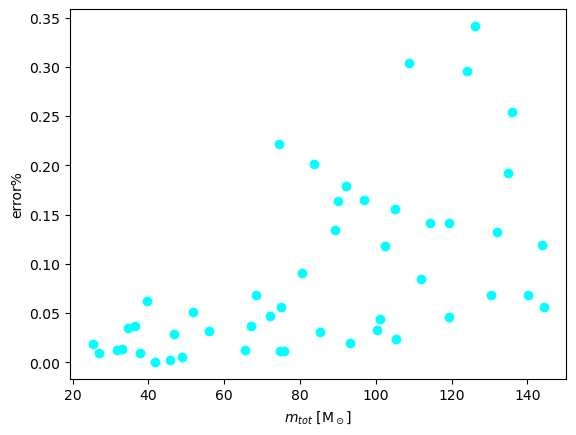

In [69]:
plt.plot(total_mass, abs(mine_['opt_snr_net']-bilby_['opt_snr_net'])/bilby_['opt_snr_net']*100, 'o', color='cyan')
plt.xlabel(r"$m_{tot}$ [$\rm M_\odot$]")
plt.ylabel(r"error%")
plt.show()

/var/folders/1k/7db4shj965v6jkny3rgd0cjc0000gn/T/ipykernel_9594/1212676004.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(mass_ratio, abs(mine_['opt_snr_net']-bilby_['opt_snr_net'])/bilby_['opt_snr_net']*100, 'o', color='cyan')


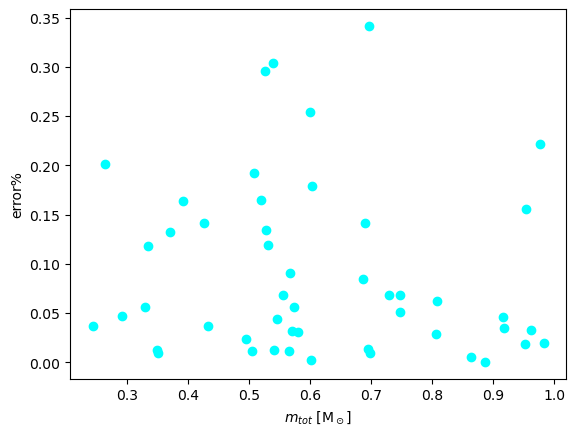

In [70]:
plt.plot(mass_ratio, abs(mine_['opt_snr_net']-bilby_['opt_snr_net'])/bilby_['opt_snr_net']*100, 'o', color='cyan')
plt.xlabel(r"$m_{tot}$ [$\rm M_\odot$]")
plt.ylabel(r"error%")
plt.show()

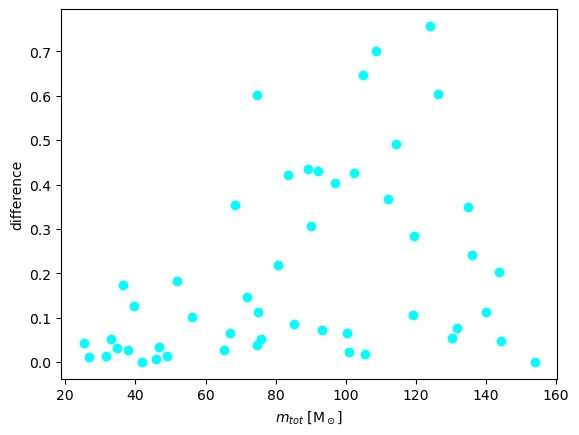

In [71]:
plt.plot(total_mass, abs(mine_['opt_snr_net']-bilby_['opt_snr_net']), 'o', color='cyan')
plt.xlabel(r"$m_{tot}$ [$\rm M_\odot$]")
plt.ylabel(r"difference")
plt.show()

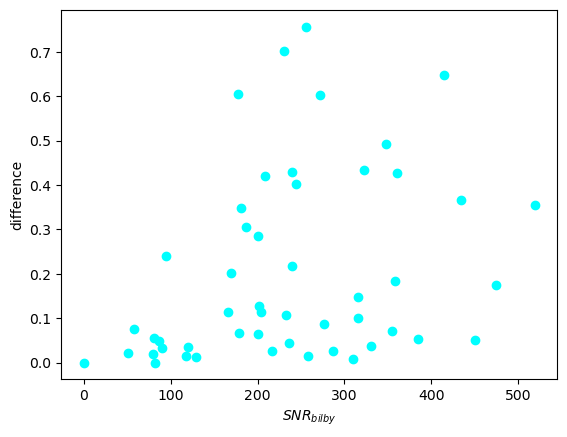

In [72]:
plt.plot(bilby_['opt_snr_net'], abs(mine_['opt_snr_net']-bilby_['opt_snr_net']), 'o', color='cyan')
plt.xlabel(r"$SNR_{bilby}$")
plt.ylabel(r"difference")
plt.show()

In [73]:
# looking that parameters with maximum error diff
index = np.argmax(mine_['opt_snr_net']-bilby_['opt_snr_net'])
print('mass_1=',mass_1[index], 'mass_2=',mass_1[index], 'luminosity_distance=',luminosity_distance[index], \
                         'theta_jn=',theta_jn[index], 'psi=',psi[index], 'phase=',phase[index], 'ra=',ra[index], 'dec=',dec[index])

mass_1= 74.35140373913102 mass_2= 74.35140373913102 luminosity_distance= 80.0 theta_jn= 5.093138723623796 psi= 2.057238865246991 phase= 6.1033074015055675 ra= 5.469865823631278 dec= 0.5791776091864528


In [74]:
quin_.compute_bilby_snr_(mass_1=mass_1[index], mass_2=mass_1[index], luminosity_distance=luminosity_distance[index], \
                         theta_jn=theta_jn[index], psi=psi[index], phase=phase[index], ra=ra[index], dec=dec[index])

{'opt_snr_net': array([177.14213084]),
 'L1': array([119.58392761]),
 'H1': array([129.04313386]),
 'V1': array([20.66127726])}

In [75]:
quin_.snr(mass_1=mass_1[index], mass_2=mass_1[index], luminosity_distance=luminosity_distance[index], iota=theta_jn[index], \
            psi=psi[index], phase=phase[index], ra=ra[index], dec=dec[index])

{'opt_snr_net': array([177.74676108]),
 'L1': array([119.99173594]),
 'H1': array([129.47872483]),
 'V1': array([20.76425284])}